In [ ]:
from looped_experiments.all import *
from looped_experiments.eval import *
import looped_experiments.wandb_utils as wu

In [ ]:
base = get_config()
filters = [lambda r: r.name == "loop_L1_b20_T5_linear"]
run = wu.get_runs(base.wandb.project, wu.default_filters + filters)["loop_L1_b20_T5_linear"]

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=20"]

In [ ]:
n_points = list(map(lambda x: f"task.n_points={x}",[10,15,20,25,30,35,40,50]))

### Error over 100 loops for with different number of in-context examples

In [ ]:
def pointwise_error(preds, ys):
    # get mean across points for each loop
    return torch.nanmean((preds - ys).square(), dim=-1).T

In [ ]:
errs = {}
for v in n_points:
    cfg = get_config(cfg_dict=run.config, overrides=eval_overrides + [v, 'model.token_dec=0', "model.n_loops=100", "model.n_loop_window=100"])
    loc = Path("../"+run.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[v] = eval(cfg, loc, pointwise_error) 

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)

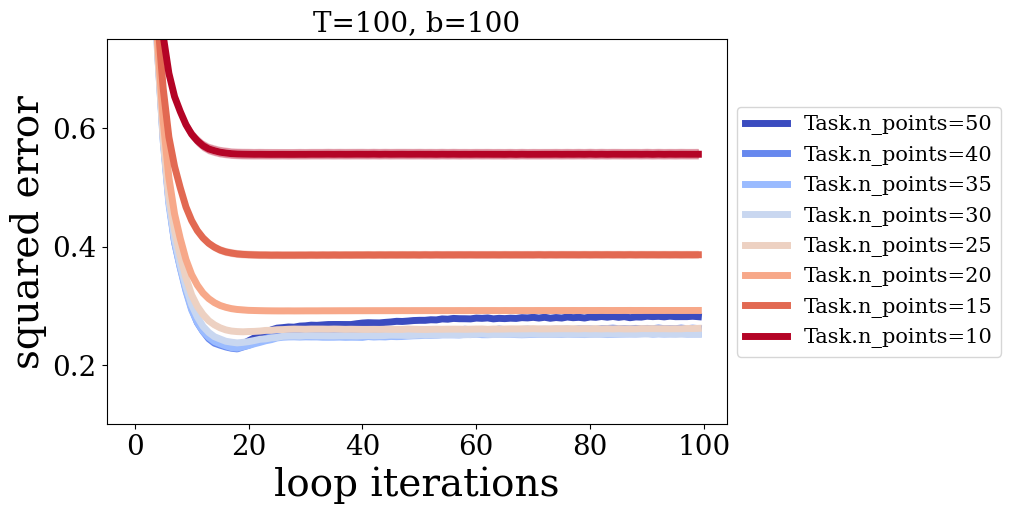

In [ ]:
ls, lw, fs = 28, 5, 15
ax = plot_results({k:res[k] for k in reversed(res.keys())})
plt.rc('font', family='serif')
ax.set_ylim(0.1, .75)
ax.set_title("T=100, b=100", fontsize=20)
ax.set_xlabel("loop iterations", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

### Error over in-context examples for different `n_loops` (b)

In [ ]:
n_loops = list(map(lambda x: f"model.n_loops={x}",[1, 2, 5, 10, 15, 20, 50, 100]))

In [ ]:
errs = {}
for v in n_loops:
    cfg = get_config(cfg_dict=run.config, overrides=eval_overrides + [v, 'model.token_dec=0', 'task.n_points=50'])
    loc = Path("../"+run.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[v] = eval(cfg, loc) 

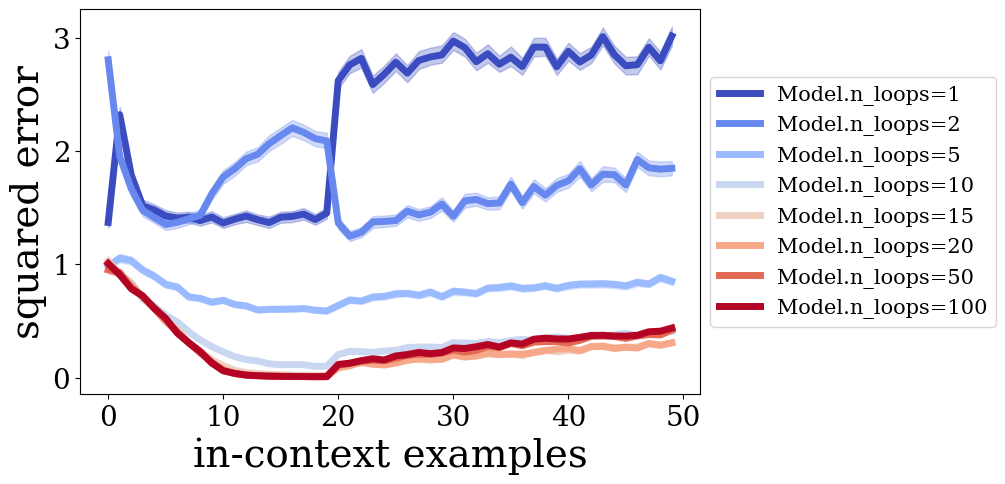

In [ ]:
res = aggregate_metrics(errs, cfg.task.n_dims)
ls, lw, fs = 28, 5, 15
ax = plot_results(res)
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)